<a href="https://colab.research.google.com/github/IgorBaratta/FEniCSxCourse/blob/ICMC23/Problem2_Transient/heat_eq.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
try:
    import gmsh
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/gmsh-install.sh" -O "/tmp/gmsh-install.sh" && bash "/tmp/gmsh-install.sh"
    import gmsh
    
try:
    import dolfinx
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/fenicsx-install-real.sh" -O "/tmp/fenicsx-install.sh" && bash "/tmp/fenicsx-install.sh"
    import dolfinx

try:
    import pyvista
except ImportError:
    !pip install - q piglet pyvirtualdisplay ipyvtklink pyvista panel
    !apt-get - qq install xvfb
    import pyvista

!wget "https://raw.githubusercontent.com/IgorBaratta/FEniCSxCourse/ICMC23/Problem2_Transient/utils.py"

# Solving a time-dependent problem


This notebook shows how to solve a transient problem using DOLFINx, 
namely the diffusion problem, the simplest extension of the Poisson problem.

The transient or unsteady version of the previous problems includes an additional term involving the rate 
of change of the physical quantity of interest. 
For the heat conduction problem the equation reads
$$
\begin{align*}
a(\mathbf{x},t)\,\dfrac{\partial{u}(\boldsymbol{x},t)}{\partial{t}} -\nabla \cdot \left ( \mu(\boldsymbol{x},t) \nabla{u}(\boldsymbol{x},t) \right) & = f(\boldsymbol{x},t) & \boldsymbol{x} \in \Omega,~~t \in [0,T] \\
& & & \\
u(\boldsymbol{x},t) & =  g(\boldsymbol{x},t) & \boldsymbol{x} \in \partial{\Omega},~~t \in [0,T] \\
& & & \\
u(\boldsymbol{x},0) & =  u_0(\boldsymbol{x}) & \boldsymbol{x} \in \partial{\Omega} &
\end{align*}
$$



Where $u(\boldsymbol{x}, t)$ is the temperature distribution at time $t$. \
$u_D$ is a prescribed function at the boundary $\partial\Omega_\text{D}$. \
And $u_0$ is the initial temperature distribution.

In general, to solve time-dependent PDEs using the finite element method, we first discretize the time derivative using a finite difference scheme which yelds a recursive series of stationary problems. We can then convert each stationary problem into a variational problem.

## Time discretization
A backward Euler scheme can be used to approximate the time derivative.
$$
\begin{align*}
  a \cdot \frac{u_{n} - u_{n-1}}{\Delta t} - \nabla \cdot (\mu \nabla u_{n}) = f_{n}
\end{align*}
$$
We may reorder the semi-discrete equation so that the left-hand side contains the terms with 
the unknown $u_{n}$ and the right-hand side contains computed terms only. 
$$
\begin{align*}
  a \, u_{n} - \Delta t \nabla \, \cdot (\mu\nabla u_{n}) = \Delta t f_{n} + a \, u_{n-1}
\end{align*}
$$


## Variational formulation
As usual we find the weak by multiplying our semi-discrete equation by a sufficiently
regular test function $v$ and applying integration by parts. \
At time-step $n$ the weak the variational problem reads: 

Find $u_n \in V(\Omega)$ such that
$$
\begin{align*}
  \int_{\Omega} a\, u_n v \,dx + \Delta t 
  \int_{\Omega}{ \mu \nabla u_n \cdot \nabla v}\,dx 
  = \Delta t \int_{\Omega} f \cdot v \, dx + \int_{\Omega} 
  a\,  u_{n-1} \cdot v \, dx
\end{align*}
$$

Again, for this problem, the natural choice is a space of scalar-valued continuous functions, 
that are element-wise polynomials of degree $k$
$$
V(\mathcal{T}_h) = V_h = \{v \in H ^ 1(\Omega), 
~v | _E \in P_k(E) \, \forall E \in \mathcal{T}_h\}
$$
Which in DOLFINx can be declared as:

    V = fem.FunctionSpace(mesh, ("Lagrange", k))

## Test problem - Manufactured Solution
We construct first a test problem for which we can easily check the answer. \
In this tutorial we create a test problem with a linear variation in time because we 
know our first-order time-stepping scheme is exact for linear functions.

$$
\begin{align*}
  u(\boldsymbol{x}, t) = c_0 x_0^2 + c_1 x_0 + c_3t
\end{align*}
$$
which produces a function whose computed values at the nodes are exact regardless 
of element size and $\Delta t$, as long as the mesh is partitioned uniformly.
Then we insert the exact solution into the strong form of our pde.
With simple manipulations we realize that the source should be:
$$
\begin{align*}
  f = c_2 - 2c_0
\end{align*}
$$
Also, at the boundaries we have:
$$
\begin{align*}
  T_D(\boldsymbol{x}, t) = c_0 x_0^2 + c_1 x_0 + c_2t
\end{align*}
$$

## Implementation

The first step is to import all modules and packages we are going to use:

In [ ]:
# Auxiliary packages
from petsc4py import PETSc # Linear algebra backend
from mpi4py import MPI     # MPI 
import numpy

# Import dolfinx and ufl modules
from dolfinx import geometry
from dolfinx import fem
from dolfinx import io
from dolfinx import la
from dolfinx.mesh import (CellType, create_unit_square, locate_entities, exterior_facet_indices)
from ufl import TestFunction, TrialFunction, dx, inner, grad

# Convenience functions for plotting on jupyter notebooks
from utils import plot_mesh
import IPython

### Creating a distributed computational domain (mesh)

To create a simple computational domain in DOLFINx, we use the mesh generation utilities in `dolfinx.mesh`.
In this module, we have the tools to build rectangles of triangular or quadrilateral elements and boxes
of tetrahedral or hexahedral elements. We start by creating a unit square:

In [ ]:
comm = MPI.COMM_WORLD
mesh = create_unit_square(comm, 10, 10, CellType.triangle)

# Compute connectivities between facets and cells
mesh.topology.create_connectivity(mesh.topology.dim - 1, mesh.topology.dim)

### Visualizing mesh
We have provided a few convenience functions for plotting on jupyter notebooks.

In [ ]:
plot_mesh(mesh, filename="mesh.html")
IPython.display.HTML(filename="mesh.html")

### Handling time-dependent functions expressions

First we define the constants we use in our program:

In [ ]:
a = fem.Constant(mesh, 1.0)
mu = fem.Constant(mesh, 1.0)
c0, c1, c2 = 1.0, 2.0, 0.5
dt = fem.Constant(mesh, 0.1)

We can now define the source term as a Constant:
$$
\begin{align*}
  f = c_2 - 2c_0
\end{align*}
$$

In [ ]:
f = fem.Constant(mesh, c2 - 2*c0)
print(type(f))

We can now define an expression that be used to compute $u$, $u_0$ and $u_D$.
Once we have this expression we can compute the coefficients of a function $u \in V_h$
by interpolation.

In [ ]:
from functools import partial 

def expression(t, x):
    return c0*x[0]**2 + c1*x[0] + c2*t

V = fem.FunctionSpace(mesh, ("Lagrange", 1))
u0 = fem.Function(V)
u0.interpolate(partial(expression, 0))

u0.name = "Temperature0"
with io.XDMFFile(MPI.COMM_WORLD, "t0.xdmf", "w") as xdmf:
    xdmf.write_mesh(mesh)
    xdmf.write_function(u0)

## Setting up a variational problem

In [ ]:
V = fem.FunctionSpace(mesh, ("Lagrange", 1))
u = TrialFunction(V)
v = TestFunction(V)

The variational form can be written in UFL syntax:
$$
\begin{align*}
  a(u, v) = \int_{\Omega} u v \,dx + \Delta t \int_{\Omega}{\nabla u \cdot \nabla v}\,dx
\end{align*}
$$

In [ ]:
a = inner(u, v) * dx + dt * inner(grad(u), grad(v)) * dx
a = fem.form(a)  # JIT compilation

$$
\begin{align*}
  L(v) = \Delta t \int_{\Omega} f \cdot v \, dx + \int_{\Omega} u_{n-1} \cdot v \, dx
\end{align*}
$$

In [ ]:
L = dt * inner(f, v) * dx + inner(u0, v) * dx
L = fem.form(L)

Note that we are using `u` for the solution that we seek at time step `n`
and `u0` for time step `n-1`.

To give the user freedom to set boundary conditions on single degrees of freedom,
the function `dolfinx.fem.dirichletbc` takes in the list of degrees of freedom(DOFs) as input.\
The DOFs on the boundary can be obtained in many ways: DOLFINx supplies a few convenience functions,
such as `dolfinx.fem.locate_dofs_topological` and `dolfinx.fem.locate_dofs_geometrical`.
DOLFINx also has convenience functions to obtain a list of all boundary facets.

In [ ]:
# Create Dirichlet function
u_D = fem.Function(V)
u_D.interpolate(partial(expression, 0))

# Define Dirichlet bc

# Get boundary facets
bndry_facets = exterior_facet_indices(mesh.topology)

# Locate degrees of freedom on those facets
tdim = mesh.topology.dim
bndry_dofs = fem.locate_dofs_topological(V, tdim - 1, bndry_facets)

# Create list of Dirichlet BC
bcs = [fem.dirichletbc(u_D, bndry_dofs)]

### Setting up a time dependent solver

As the left hand side of our problem(the matrix) is time independent, we would like avoid 
re-assembling it at every time step.We assemble the matrix once outside the temporal loop.

In [ ]:
A = fem.petsc.assemble_matrix(a, bcs=bcs)
A.assemble()

# https://www.mcs.anl.gov/petsc/petsc4py-current/docs/apiref/petsc4py.PETSc.Mat-class.html
info = A.getInfo()

Next, we can generate the integration kernel for the right hand side(RHS), 
and create the RHS vector `b` that we will assembled into at each time step.

In [ ]:
b = fem.Function(V)

We next create the PETSc KSP(Krylov subspace method) solver, and set it to solve using an
[algebraic multigrid method](https: // hypre.readthedocs.io/en/latest/solvers-boomeramg.html).

In [ ]:
# Define Solver
solver = PETSc.KSP().create(comm)
solver.setOperators(A)
solver.setType(PETSc.KSP.Type.CG)
pc = solver.getPC()
# https://www.mcs.anl.gov/petsc/petsc4py-current/docs/apiref/petsc4py.PETSc.PC.Type-class.html
pc.setType("gamg")

### Plotting a time dependent problem

As we are solving a time dependent problem, we would like to create a time dependent animation 
of the solution. The first step is to create an output file where we are going to save the 
solution at each time step:

In [ ]:
# Open file, keep it 
file = io.XDMFFile(MPI.COMM_WORLD, "temperature.xdmf", "w")
file.write_mesh(mesh)

## Solving a time dependent problem

We are now ready to solve the time dependent problem. At each time step, we need to:
1. Update the time dependent boundary condition and source
2. Reassemble the right hand side vector $b$ that depends on $u_{n-1}$
3. Apply boundary conditions to $b$
4. Solve linear problem $AU = b$
5. Update current solution, $u_{n-1} = u_n$

In [ ]:
u = fem.Function(V)
u.name = "temperature"

t = 0
t_max = 100*dt.value
while t < t_max:
    t += dt.value
    print(f"t = {t:.2f} s")

    # Update boundary condition
    u_D.interpolate(partial(expression, t))

    # Assemble RHS
    b.x.array[:] = 0
    fem.petsc.assemble_vector(b.vector, L)

    # Apply boundary condition
    fem.petsc.apply_lifting(b.vector, [a], [bcs])
    b.x.scatter_reverse(la.ScatterMode.add)
    fem.petsc.set_bc(b.vector, bcs)

    # Solve linear problem
    u.x.array[:] = 0
    solver.solve(b.vector, u.vector)
    u.x.scatter_forward()

    # Update un
    u0.x.array[:] = u.x.array

    # Save solution at time step t
    file.write_function(u, t=t)

# Now we can close the file
file.close()

In [ ]:
from google.colab import files
files.download('temperature.xdmf') 
files.download('temperature.h5')

### What's the temperature at an arbitrary point $\boldsymbol{x}_p$?
Remember that 
$$
u_h(\boldsymbol{x}) = \sum_{i=1}^{dim{V_h}}{u_j \psi_j(\boldsymbol{x}})
$$

Once we find the values of of coefficients, its just a matter of evaluation the basis functions
at $\boldsymbol{x}_p$.

In [ ]:
# Given an arbitrary point "xp"
xp = numpy.array([0.5, 0.5, 0.0], dtype=numpy.float64)

# We first compute the cells that it belongs to
bb_tree = geometry.BoundingBoxTree(mesh, mesh.topology.dim)
cell_candidates = geometry.compute_collisions(bb_tree, xp)
cells = geometry.compute_colliding_cells(mesh, cell_candidates, xp)

# Given a list of cells it's easy and "efficient" to compute T(p)
values = u.eval(xp, cells[0])
print(f"Temperature at point {xp} is {values[0]}")

**TASK 1**: The above time-stepping loop does not include any 
comparison of numerical and exact solutions, which is required 
to validate the implementation. In the previous section we've 
learned how to compute the L2 and H1 error norms.

Use the knowledge gained in the previous section to calculate both
the L2 and H1 error norms for $t=t_{max}$.

In [ ]:
# Solution goes here:


# Homework 2

In this homework we are going to tackle a more physically realistic problem.
Given the temperature outside a room, we shall compute the temperature inside
the room, and find the appropriate insulation material. 

Without internal sources the strong form of our problem reads:
$$
\begin{align*}
\rho C_p\frac{\partial u}{\partial t} &= \nabla \cdot (\kappa  \nabla u) & & \text{in } \, \Omega, \\
u(\boldsymbol{x}, t) &= u_D = u_R + u_a \cdot sin(\omega t) & & \,\partial\Omega_\text{D}, \\
u(\boldsymbol{x}, t=0) &= u_0 & & \text{in } \, \Omega,
\end{align*}
$$
where $k$ is the thermal conductivity, $\rho$ is the density and $C_p$ is the 
is specific heat capacity.

In this example, we assume computational domain is divided into 
two domains $\Omega_{air}$ and $\Omega_{wall}$. Within each domain
we can define the thermal diffusivity of the medium $\alpha$:
$$
\begin{align*}
\alpha = \frac{k}{\rho C_p}
\end{align*}
$$

Examples of thermal diffusivity for four different materials:
$$\alpha_{air} = 19 \cdot 10^{-6} \, m^2/s$$
$$\alpha_{glass} = 0.34	 \cdot 10^{-6} \, m^2/s$$
$$\alpha_{brick} = 0.27 \cdot 10^{-6} \, m^2/s$$
$$\alpha_{wood} = 0.082 \cdot 10^{-6} \, m^2/s$$
$$\alpha_{steel} = 11.72 \cdot 10^{-6} \, m^2/s$$

**Question**: Given unit square room $[1m \times 1m]$, $0.1 m$ thick walls, and outside temperature given by $u_D$, which material should be used for the wall 
such that the temperature at the center of the room never drops below 
$10^oC$?

**TASK 1**: Complete following code with the diffusivity of the wall 
(chosen from the above values). Then visualize the material distribution.

In [40]:
def wall(x):
    vertical = (x[0] <= 0.1) | (x[0] >= 0.9)
    horizontal = (x[1] <= 0.1) | (x[1] >= 0.9)
    return horizontal | vertical


comm = MPI.COMM_WORLD
mesh = create_unit_square(comm, 20, 20, CellType.quadrilateral)

cells = locate_entities(mesh, mesh.topology.dim, wall)
DG = fem.FunctionSpace(mesh, ("DG", 0))

# Thermal diffusivity
alpha = fem.Function(DG)
alpha.x.array[:] = 19e-6

# Edit here: diffusivity of wall
alpha.x.array[cells] = 0.27e-6

plot_mesh(mesh, cell_values=alpha, filename="alpha.html")
IPython.display.HTML(filename="alpha.html")

**Task 2**: create a python function that defines the outside temperature
$$u_{out} = -5 + 15 \cdot |sin(\omega t)|$$
where $\omega = \pi/(24\cdot60\cdot60)$. 
Plot the temperature for a period of 48 hours.

Text(0, 0.5, 'Temperature ($^oC$)')

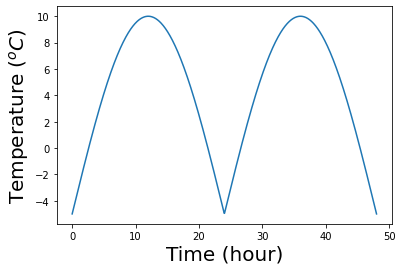

In [91]:
period = 60*60*24 # seconds in a day
def outside_temperature(t, x):
    # Edit this function
    temperature = 0.
    return numpy.full_like(x[0], temperature)

# Task: Plot the hourly temperature during a day:
time = numpy.linspace(0, 48*60*60, 1000)
temp = numpy.zeros_like(time)
for i, t in enumerate(time):
    point = numpy.array([[0., 0.]]).T
    temp[i] = outside_temperature(t, point)[0]


import matplotlib.pyplot as plt
plt.plot(time/(60*60), temp)
plt.xlabel('Time (hour)', fontsize=20)
plt.ylabel('Temperature ($^oC$)', fontsize=20)

**Task 3**: Modify the following thermal solver so that it returns the temperature inside the room at each time step.
Save the solution at each time-step and visualize with paraview.

In [103]:
def thermal_solver(alpha, intial_temp=15, time_step=900.0):
    mesh = alpha.function_space.mesh

    # Create function space
    V = fem.FunctionSpace(mesh, ("Lagrange", 1))
    
    # Define trial and test functions
    u = TrialFunction(V)
    v = TestFunction(V)

    # Initial condition
    u0 = fem.Function(V)
    u0.interpolate(lambda x: numpy.full_like(x[0], intial_temp))

    # Time step (15 min - 900 seconds)
    dt = fem.Constant(mesh, time_step)

    # Bilinear form
    a = inner(u, v) * dx + dt * alpha * inner(grad(u), grad(v)) * dx
    a = fem.form(a)

    # Linear form
    L = inner(u0, v) * dx
    L = fem.form(L)  # JIT compilation


    # Define dirichlet bc at t=0
    temp0 = partial(outside_temperature, 0)
    u_D = fem.Function(V)
    u_D.interpolate(temp0)
    
    # Create boundary condition
    tdim = mesh.topology.dim
    mesh.topology.create_connectivity(tdim - 1, tdim)
    bndry_facets = exterior_facet_indices(mesh.topology)
    bndry_dofs = fem.locate_dofs_topological(V, tdim - 1, bndry_facets)
    bcs = [fem.dirichletbc(u_D, bndry_dofs)]

    # Assemble matrix A and RHS b
    A = fem.petsc.assemble_matrix(a, bcs=bcs)
    A.assemble()
    b = fem.Function(V)

    solver = PETSc.KSP().create(comm)
    solver.setOperators(A)
    solver.setType(PETSc.KSP.Type.CG)
    pc = solver.getPC()
    pc.setType("gamg")

    u = fem.Function(V)
    u.interpolate(u0)

    # Check against standard table value
    # Create bounding box for function evaluation
    bb_tree = geometry.BoundingBoxTree(mesh, mesh.topology.dim)
    p = numpy.array([0.5, 0.5, 0.0], dtype=numpy.float64)
    cell_candidates = geometry.compute_collisions(bb_tree, p)
    cells = geometry.compute_colliding_cells(mesh, cell_candidates, p)

    value = u.eval(p, cells[0])
    print(f"Room temperature {value} at time t=0")

    t = 0
    num_days = 2
    t_max = period * num_days

    # Array to store temperature
    temperature = [value]
    time = [t]

    while t < t_max:
        time.append(t)
        t += dt.value

        # Update boundary condition
        u_D.interpolate(partial(outside_temperature, t))

        # Assemble RHS
        b.x.array[:] = 0
        fem.petsc.assemble_vector(b.vector, L)

        # Apply boundary condition
        fem.petsc.apply_lifting(b.vector, [a], [bcs])
        # b.x.scatter_reverse(ScatterMode.add)
        fem.petsc.set_bc(b.vector, bcs)

        # Solve linear problem
        solver.solve(b.vector, u.vector)
        u.x.scatter_forward()

        ##### TODO
        ###### Evaluate u an append to "temperature"

        # Update un
        u0.x.array[:] = u.x.array
    
    return temperature, time

**Task 4**: Which material should we use for insulation?
Modify the alpha value on the wall and plot temperature
vs time inside the room.

Room temperature [15.] at time t=0
Room temperature [15.] at time t=0
Room temperature [15.] at time t=0


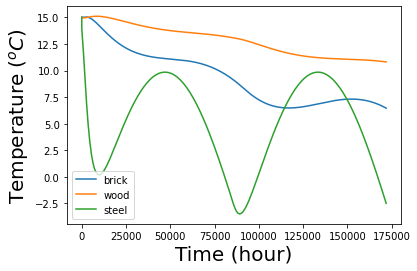

In [109]:
alpha.x.array[cells] = 0.27e-6
temperature, time = thermal_solver(alpha)
import matplotlib.pyplot as plt
plt.plot(time, temperature, label="brick")
assert len(temperature) == len(time)

## Complete with different material

plt.xlabel('Time (hour)', fontsize=20)
plt.ylabel('Temperature ($^oC$)', fontsize=20)
plt.legend()